# Karhunen Loeve expansion model error for simplified ocean state

Practicalities to consider:
We can choose between sine and cosine basis functions.
* sine gives zero along the boundary, which ensures that we can use it for periodic BC
    * We can use sine with random rolling to make the zero "boundary" appear as a random cross in the domain
    * The derivative is discontinous at the periodic boundary, which leads to wierd currents
* cosine basis simply looks better, but is not periodic 
    * The derivative at the boundary is zero, which means it will look great if it is mirrored
    * By expanding the basis to [0, 2 pi], we get a periodic field with periodic derivatives, but it will have wierd patterns...


If we restrict ourselves to wall BC, we get the following optimal:
* cosine basis functions on [0, pi] without rolling.

Better approach:
* Use both sine and cosine basis functions between 0 and 2*pi with random rolling

In [14]:
import numpy as np
from matplotlib import pyplot as plt



In [347]:
class KarhunenLoeve_Sampler():
    """ Sampling random field based on Karhunen-Loeve expansions """
    
    def __init__(self, Nx, Ny, sine=True, kl_decay=1.05, kl_scaling=0.15, KL_bases_start=1, KL_bases_end=10):
        """
        t_splits (int) - number of how many KL-fields are generated
        KL_N (int)     - spatial resolution of KL-fields
        """

        self.KL_DECAY = kl_decay
        self.KL_SCALING = kl_scaling

        self.KL_bases_start = KL_bases_start
        self.KL_bases_end   = KL_bases_end
        self.KL_bases_N = KL_bases_end - KL_bases_start + 1

        self.Ny        = Ny
        self.Nx        = Nx
        self.half_dx  = 1.0/(2*Nx)
        self.half_dy  = 1.0/(2*Ny)
        
        self.KL_ref_fields = np.zeros((self.KL_bases_N, self.KL_bases_N, self.Ny, self.Nx))

        self.sine = sine
        
        for n in range(0, self.KL_bases_N):
            for m in range(0, self.KL_bases_N):
                self.KL_ref_fields[n, m, :, :] = self.get_ref_field(self.KL_bases_start + m,
                                                                    self.KL_bases_start + n)

        self.KL_ref_fields = np.reshape(self.KL_ref_fields, (self.KL_bases_N * self.KL_bases_N, self.Ny, self.Nx))

    def get_rns(self):
        return np.random.normal(size=self.KL_bases_N * self.KL_bases_N)

    def get_ref_field(self, m, n):
        if self.sine:
            return self.KL_SCALING * m**(-self.KL_DECAY) * n**(-self.KL_DECAY) * np.outer(np.sin(2*m*np.pi*np.linspace(self.half_dy,1-self.half_dy,self.Ny)), 
                                                                                          np.sin(2*n*np.pi*np.linspace(self.half_dx,1-self.half_dx,self.Nx))) 
        else:
            return self.KL_SCALING * m**(-self.KL_DECAY) * n**(-self.KL_DECAY) * np.outer(np.cos(2*m*np.pi*np.linspace(self.half_dy,1-self.half_dy,self.Ny)), 
                                                                                          np.cos(2*n*np.pi*np.linspace(self.half_dx,1-self.half_dx,self.Nx)))     

    def perturbations(self, rns=None, random_roll=False):
        """ Output: size=(t_splits, N, N) with t_splits-times a KL-field """

        if rns is None:
            rns = self.get_rns()
        assert(rns.shape == (self.KL_bases_N * self.KL_bases_N,))

        KL_field = np.sum(self.KL_ref_fields*rns[:,np.newaxis, np.newaxis], axis=0)
        if random_roll:
            roll_x = int(np.floor(np.random.rand()*self.Nx))
            roll_y = int(np.floor(np.random.rand()*self.Ny))
            return np.roll(np.roll(KL_field, roll_y, 0), roll_x, 1)
        return KL_field

bases_start = 2
bases_end = 8
kls_sin = KarhunenLoeve_Sampler(1000,700, kl_decay=1.5, kl_scaling=1.0, KL_bases_start=bases_start, KL_bases_end=bases_end)
kls_cos = KarhunenLoeve_Sampler(1000, 700, sine=False, kl_decay=1.2, kl_scaling=1.0, KL_bases_start=bases_start, KL_bases_end=bases_end)


In [308]:
int(np.floor(np.random.rand()*100))

43

In [345]:
rns = kls_sin.get_rns()
rns.shape

(49,)

-0.22644738822882565


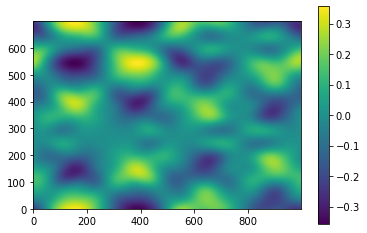

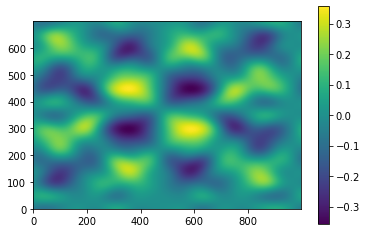

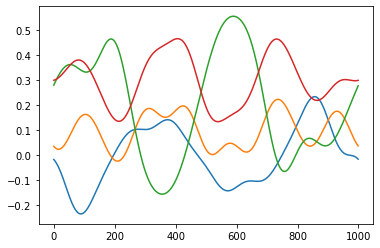

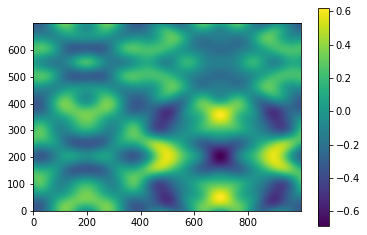

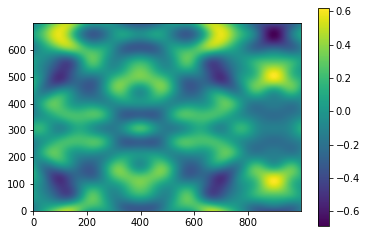

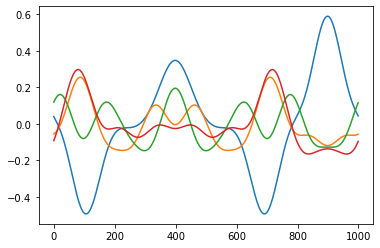

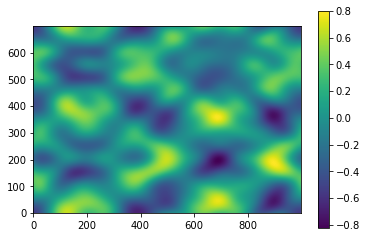

In [348]:
rns = kls_sin.get_rns()
pert_sin  = kls_sin.perturbations(rns, random_roll=True)
pert_cos  = kls_cos.perturbations(rns, random_roll=True)
fig=plt.figure(); plt.imshow(pert_sin, origin="lower"); plt.colorbar()
fig=plt.figure(); plt.imshow(np.roll(np.roll(pert_sin, 200, 1), 454, 0), origin="lower"); plt.colorbar()
fig=plt.figure(); 
plt.plot(np.roll(np.roll(pert_sin, 200, 1), 454, 0)[100, :])
plt.plot(np.roll(np.roll(pert_sin, 200, 1), 454, 0)[200, :] + 0.1)
plt.plot(np.roll(np.roll(pert_sin, 200, 1), 454, 0)[300, :] + 0.2)
plt.plot(np.roll(np.roll(pert_sin, 200, 1), 454, 0)[400, :] + 0.3)

fig=plt.figure(); plt.imshow(pert_cos, origin="lower"); plt.colorbar()
fig=plt.figure(); plt.imshow(np.roll(np.roll(pert_cos, 200, 1), 454, 0), origin="lower"); plt.colorbar()
print(pert_sin[0,0])
fig=plt.figure(); 
plt.plot(np.roll(np.roll(pert_cos, 200, 1), 454, 0)[100, :])
plt.plot(np.roll(np.roll(pert_cos, 200, 1), 454, 0)[200, :])
plt.plot(np.roll(np.roll(pert_cos, 200, 1), 454, 0)[300, :])
plt.plot(np.roll(np.roll(pert_cos, 200, 1), 454, 0)[400, :])


fig=plt.figure(); plt.imshow(pert_cos+pert_sin, origin="lower"); plt.colorbar()



(100,) 10


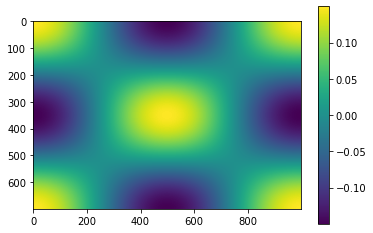

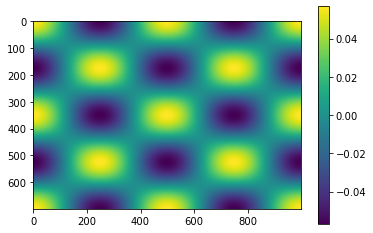

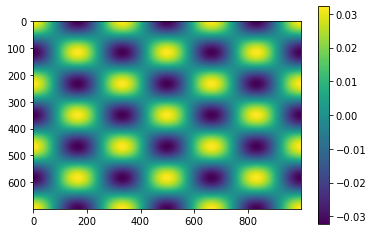

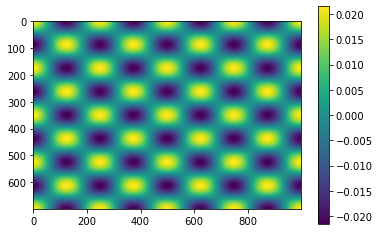

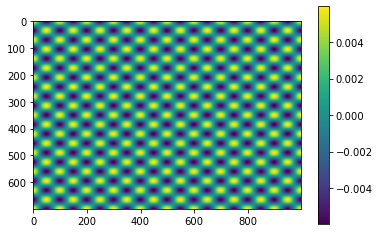

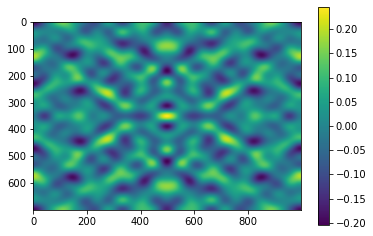

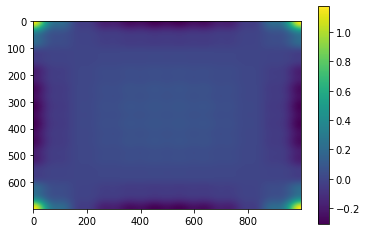

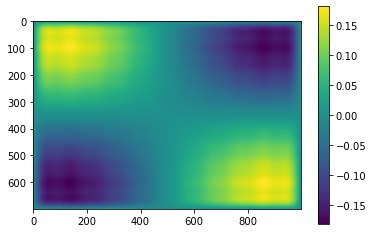

In [337]:
kls = KarhunenLoeve_Sampler(1000, 700, sine=False, kl_decay=0.7, KL_bases_start=3, KL_bases_end=12)

print(rns.shape, kls.KL_bases_N)

fig = plt.figure()
plt.imshow(kls.get_ref_field(1,1))
plt.colorbar()
fig = plt.figure()
plt.imshow(kls.get_ref_field(2,2))
plt.colorbar()
fig = plt.figure()
plt.imshow(kls.get_ref_field(3,3))
plt.colorbar()
fig = plt.figure()
plt.imshow(kls.get_ref_field(4,4))
plt.colorbar()
fig = plt.figure()
plt.imshow(kls.get_ref_field(10,10))
plt.colorbar()


fig = plt.figure()
plt.imshow(kls.perturbations(rns))
plt.colorbar()

kls = KarhunenLoeve_Sampler(1000, 700, sine=False)
fig = plt.figure()
plt.imshow(kls.perturbations(np.ones_like(rns)))
plt.colorbar()

fig = plt.figure()
plt.imshow(kls_sin.perturbations(np.ones_like(rns)))
plt.colorbar()

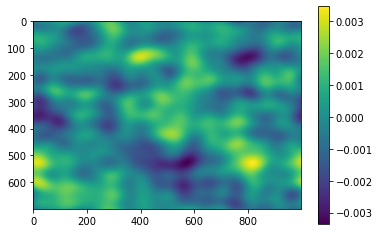

In [297]:
kls = KarhunenLoeve_Sampler(1000, 700, sine=False, kl_decay=0.94)

f = kls.perturbations()
for i in range(1, 100):
    f = f + kls.perturbations(random_roll=True)
f = f/1000


plt.imshow(f)
plt.colorbar()


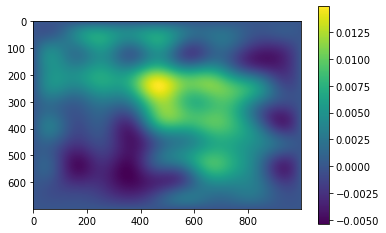

In [187]:
kls = KarhunenLoeve_Sampler(1000, 700, sine=True, kl_decay=0.94)

f = kls.perturbations()
for i in range(1, 100):
    f = f + kls.perturbations()
f = f/1000


plt.imshow(f)
plt.colorbar()


# Testing the model error class

In [349]:
kls.KL_ref_fields.shape

(100, 700, 1000)